# Offline RL (80 Points)

> Name: Naser Kazemi

> SID: 99102059




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm


from torch.utils.data import DataLoader, Dataset


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [ ]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO
        # Define your network layers
        ##########################################################
        self.fc1 = nn.Linear(input_dimension, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        ##########################################################
        # TODO
        # Calculate the output
        ##########################################################
        x = F.relu(self.fc1(inpt))
        x = F.relu(self.fc2(x))
        output = self.output_activation(self.fc3(x))
        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [ ]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [ ]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
        # TODO
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(self.state_dim, 1)
        self.critic_local2 = Network(self.state_dim, 1)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        self.critic_target = Network(self.state_dim, 1)
        self.critic_target2 = Network(self.state_dim, 1)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, output_activation=torch.nn.Softmax(dim=-1))
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO
        # You are going to calculate critic losses in this method
        ##########################################################

        next_action_probs, next_log_action_probs = self.get_action_info(states_tensor)
        q_target_next = self.critic_target(next_states_tensor).squeeze()
        q_target2_next = self.critic_target2(next_states_tensor).squeeze()
        q_target_next = torch.min(q_target_next, q_target2_next) - self.alpha * next_log_action_probs.gather(1, actions_tensor.unsqueeze(1).long()).squeeze()
        q_targets = rewards_tensor + (1 - done_tensor.long()) * self.discount * q_target_next

        q_expected1 = self.critic_local(states_tensor)
        q_expected2 = self.critic_local2(states_tensor)

        critic_loss = F.mse_loss(q_expected1.squeeze(), q_targets)
        critic2_loss = F.mse_loss(q_expected2.squeeze(), q_targets)

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        # TODO
        # Implement the actor loss
        ##########################################################
        action_probs, log_action_probs = self.get_action_info(states_tensor)
        q1_values = self.critic_local(states_tensor)
        q2_values = self.critic_local2(states_tensor)
        q_values = torch.min(q1_values, q2_values)

        actor_loss = (self.alpha * log_action_probs.gather(1, actions_tensor.unsqueeze(1).long()).squeeze() - q_values).mean()
        log_action_probabilities = log_action_probs.gather(1, actions_tensor.unsqueeze(1).long()).squeeze()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline and transition is not None:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward(retain_graph=True)
            critic2_loss.backward(retain_graph=True)

            self.critic_optimiser.step()
            self.critic_optimiser2.step()


            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Run 1, Episode 20, Mean Reward: 59.3, Std Dev: 39.819718733311014
Run 1, Episode 40, Mean Reward: 92.9, Std Dev: 18.517289218457435
Run 1, Episode 60, Mean Reward: 188.3, Std Dev: 13.236691429507601
Run 1, Episode 80, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 100, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 120, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 140, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 160, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 180, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 200, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 220, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 240, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 260, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 280, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 300, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 320, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 340, Mean Reward: 200.0, Std Dev: 0.0
Run 1, Episode 360, Mean Reward: 200.0, Std Dev: 0.0
Run 1, 

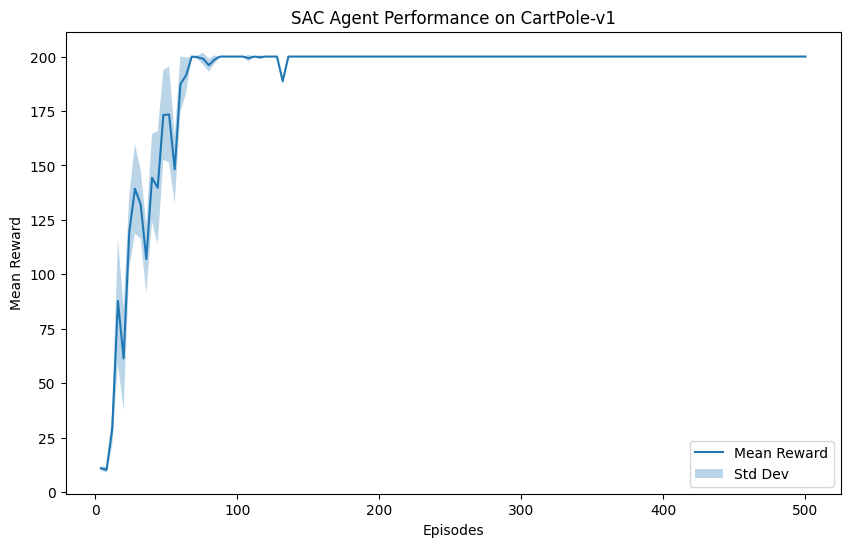

In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################


def evaluate_agent(agent, test_env, episodes=10, steps=200):
    total_rewards = []
    for _ in range(episodes):
        state = test_env.reset()
        episode_reward = 0
        for _ in range(steps):
            action = agent.get_next_action(state, evaluation_episode=True)
            next_state, reward, done, _ = test_env.step(action)
            episode_reward += reward
            state = next_state
            if done:
                break
        total_rewards.append(episode_reward)
    return np.mean(total_rewards), np.std(total_rewards)


all_runs_mean_rewards = []
all_runs_std_rewards = []

NUM_RUNS = 4

for run in range(NUM_RUNS):
    agent = SACAgent(env, learning_rate=0.005)
    run_mean_rewards = []
    run_std_rewards = []

    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        for _ in range(STEPS_PER_EPISODE):
            action = agent.get_next_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            if done:
                break

        if (episode + 1) % TRAINING_EVALUATION_RATIO == 0:
            mean_reward, std_reward = evaluate_agent(agent, test_env)
            run_mean_rewards.append(mean_reward)
            run_std_rewards.append(std_reward)
        if (episode + 1) % (5 * TRAINING_EVALUATION_RATIO) == 0:
            print(f"Run {run + 1}, Episode {episode + 1}, Mean Reward: {mean_reward}, Std Dev: {std_reward}")

    all_runs_mean_rewards.append(run_mean_rewards)
    all_runs_std_rewards.append(run_std_rewards)

# Plot the mean and standard deviation of evaluation curves
mean_rewards = np.mean(all_runs_mean_rewards, axis=0)
std_rewards = np.mean(all_runs_std_rewards, axis=0)

episodes = np.arange(TRAINING_EVALUATION_RATIO, EPISODES_PER_RUN + 1, TRAINING_EVALUATION_RATIO)

plt.figure(figsize=(10, 6))
plt.plot(episodes, mean_rewards, label='Mean Reward')
plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3, label='Std Dev')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('SAC Agent Performance on CartPole-v1')
plt.legend()
plt.show()


In [ ]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 300
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")

online_agent = SACAgent(env, learning_rate=0.005)


for run in range(1, 4 + 1):
    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        for _ in range(STEPS_PER_EPISODE):
            action = online_agent.get_next_action(state)
            next_state, reward, done, _ = env.step(action)
            online_agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            if done:
                break

        if (episode + 1) % 25 == 0:
            print(f"Run {run}, Episode {episode + 1}")

buffer = online_agent.replay_buffer

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 1, Episode 25
Run 1, Episode 50
Run 1, Episode 75
Run 1, Episode 100
Run 1, Episode 125
Run 1, Episode 150
Run 1, Episode 175
Run 1, Episode 200
Run 1, Episode 225
Run 1, Episode 250
Run 1, Episode 275
Run 1, Episode 300
Run 2, Episode 25
Run 2, Episode 50
Run 2, Episode 75
Run 2, Episode 100
Run 2, Episode 125
Run 2, Episode 150
Run 2, Episode 175
Run 2, Episode 200
Run 2, Episode 225
Run 2, Episode 250
Run 2, Episode 275
Run 2, Episode 300
Run 3, Episode 25
Run 3, Episode 50
Run 3, Episode 75
Run 3, Episode 100
Run 3, Episode 125
Run 3, Episode 150
Run 3, Episode 175
Run 3, Episode 200
Run 3, Episode 225
Run 3, Episode 250
Run 3, Episode 275
Run 3, Episode 300
Run 4, Episode 25
Run 4, Episode 50
Run 4, Episode 75
Run 4, Episode 100
Run 4, Episode 125
Run 4, Episode 150
Run 4, Episode 175
Run 4, Episode 200
Run 4, Episode 225
Run 4, Episode 250
Run 4, Episode 275
Run 4, Episode 300


In [ ]:
env = gym.make("CartPole-v1")
online_agent = SACAgent(env, replay_buffer=buffer, learning_rate=0.005)
EPISODES_PER_RUN = 300
STEPS_PER_EPISODE = 200


for run in range(5, 5 + 1):
    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        for _ in range(STEPS_PER_EPISODE):
            action = online_agent.get_next_action(state)
            next_state, reward, done, _ = env.step(action)
            online_agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            if done:
                break

        if (episode + 1) % 25 == 0:
            print(f"Run {run}, Episode {episode + 1}")

buffer = online_agent.replay_buffer

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 5, Episode 25
Run 5, Episode 50
Run 5, Episode 75
Run 5, Episode 100
Run 5, Episode 125
Run 5, Episode 150
Run 5, Episode 175
Run 5, Episode 200
Run 5, Episode 225
Run 5, Episode 250
Run 5, Episode 275
Run 5, Episode 300


In [ ]:
env = gym.make("CartPole-v1")
online_agent = SACAgent(env, replay_buffer=buffer, learning_rate=0.005)
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200


for run in range(5, 5 + 1):
    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        for _ in range(STEPS_PER_EPISODE):
            action = online_agent.get_next_action(state)
            next_state, reward, done, _ = env.step(action)
            online_agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            if done:
                break

        if (episode + 1) % 25 == 0:
            print(f"Run {run}, Episode {episode + 1}")

buffer = online_agent.replay_buffer

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 5, Episode 25
Run 5, Episode 50
Run 5, Episode 75
Run 5, Episode 100
Run 5, Episode 125
Run 5, Episode 150
Run 5, Episode 175
Run 5, Episode 200
Run 5, Episode 225
Run 5, Episode 250
Run 5, Episode 275
Run 5, Episode 300
Run 5, Episode 325
Run 5, Episode 350
Run 5, Episode 375
Run 5, Episode 400
Run 5, Episode 425
Run 5, Episode 450
Run 5, Episode 475
Run 5, Episode 500


In [ ]:
# load the buffer pickle
import pickle
with open('buffer.pkl', 'rb') as f:
    buffer = pickle.load(f)

In [ ]:
# save the buffer pickle
import pickle
with open('buffer.pkl', 'wb') as f:
    pickle.dump(buffer, f)

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(300):
    frames.append(env.render()[0])
    action = online_agent.get_next_action(state, evaluation_episode=True)
    state, reward, terminated, truncated = env.step(action)
    if terminated or truncated:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 10, Mean Reward: 9.7, Std Dev: 1.9000000000000001
Episode 20, Mean Reward: 29.05, Std Dev: 44.86142552349401
Episode 30, Mean Reward: 82.56666666666666, Std Dev: 84.66509841067267
Episode 40, Mean Reward: 111.925, Std Dev: 89.22930782540006
Episode 50, Mean Reward: 129.54, Std Dev: 87.23903025595826
Episode 60, Mean Reward: 141.28333333333333, Std Dev: 83.85544936907135
Episode 70, Mean Reward: 149.67142857142858, Std Dev: 80.3079290567734
Episode 80, Mean Reward: 155.9625, Std Dev: 76.94307047259032
Episode 90, Mean Reward: 160.85555555555555, Std Dev: 73.85098526554238
Episode 100, Mean Reward: 164.77, Std Dev: 71.03856065546374


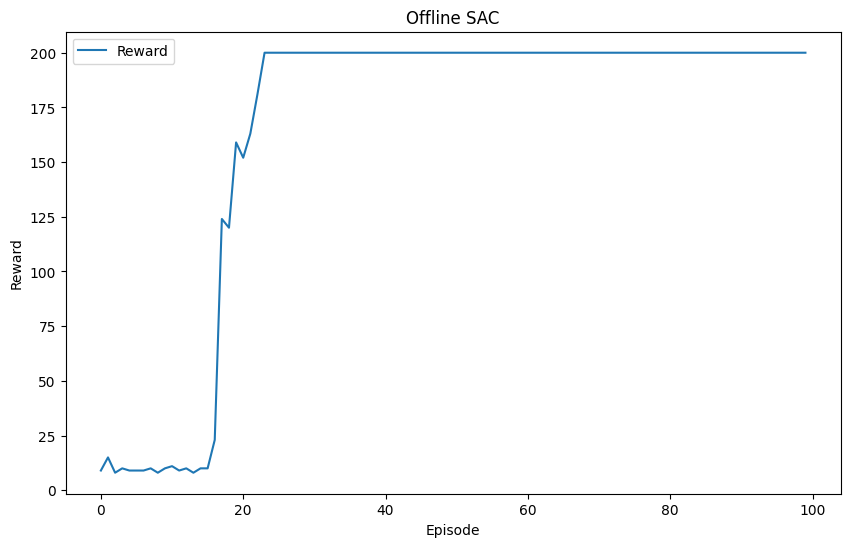

In [ ]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################

offline_agent = SACAgent(environment=env, replay_buffer=buffer, offline=True, learning_rate=0.005)

rewards = []

for episode in range(EPISODES_PER_RUN):
    state = env.reset()
    for step in range(NUM_EPOCHS):
        offline_agent.train_networks()

    state = env.reset()
    sum_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = offline_agent.get_next_action(state, evaluation_episode=True)
        state, reward, terminated, truncated = env.step(action)
        sum_reward += reward
        if terminated or truncated:
          break

    rewards.append(sum_reward)

    if (episode + 1) % (10) == 0:
        mean_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f"Episode {episode + 1}, Mean Reward: {mean_reward}, Std Dev: {std_reward}")




plt.figure(figsize=(10, 6))
plt.plot(rewards, label = "Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Offline SAC")
plt.legend()
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(300):
    frames.append(env.render()[0])
    action = offline_agent.get_next_action(state, evaluation_episode=True)
    state, reward, terminated, truncated = env.step(action)
    if terminated or truncated:
        break
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [ ]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

# TODO
# Collect state-action pairs
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    terminated = False
    while not terminated:
        action = online_agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, terminated, truncated = env.step(action)
        expert_data.append((state, action))
        state = next_state


with open('expert_data.pkl', 'wb') as f:
    pickle.dump(expert_data, f)

100%|██████████| 1000/1000 [01:58<00:00,  8.43it/s]


Define the model for behaviuoral cloning.

In [ ]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # TODO
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # TODO
        # Perform forward pass
        x = F.relu(self.fc1(x))
        output = F.softmax(self.fc2(x), dim=1)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [ ]:
class ExpertDataset(Dataset):
    def __init__(self, expert_data):
        self.expert_data = expert_data

    def __len__(self):
        return len(self.expert_data)

    def __getitem__(self, idx):
        state, action = self.expert_data[idx]
        return torch.tensor(state, dtype=torch.float32), torch.tensor(action, dtype=torch.long)

In [ ]:
input_dimension = env.observation_space.shape[0]
hidden_dimension = 64
output_dimension = env.action_space.n
learning_rate = 0.005


bc_model = BCModel(input_dimension, hidden_dimension, output_dimension)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bc_model.parameters(), lr=learning_rate)

num_epochs = 10
batch_size = 128

dataloader = DataLoader(ExpertDataset(expert_data), batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    total_loss = 0
    # TODO
    # Implement behavioural cloning training loop
    for states, actions in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = bc_model(states)
        loss = criterion(outputs, actions)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


torch.save(bc_model.state_dict(), 'bc_model.pth')

Epoch 1/10: 100%|██████████| 3907/3907 [00:22<00:00, 174.46it/s]


Epoch 1/10, Loss: 1475.2962810099125


Epoch 2/10: 100%|██████████| 3907/3907 [00:21<00:00, 179.16it/s]


Epoch 2/10, Loss: 1288.8422367870808


Epoch 3/10: 100%|██████████| 3907/3907 [00:20<00:00, 191.78it/s]


Epoch 3/10, Loss: 1268.4043707549572


Epoch 4/10: 100%|██████████| 3907/3907 [00:22<00:00, 177.58it/s]


Epoch 4/10, Loss: 1260.1829808950424


Epoch 5/10: 100%|██████████| 3907/3907 [00:23<00:00, 167.74it/s]


Epoch 5/10, Loss: 1255.6658509075642


Epoch 6/10: 100%|██████████| 3907/3907 [00:21<00:00, 184.45it/s]


Epoch 6/10, Loss: 1252.7651771306992


Epoch 7/10: 100%|██████████| 3907/3907 [00:29<00:00, 134.12it/s]


Epoch 7/10, Loss: 1250.5209258794785


Epoch 8/10: 100%|██████████| 3907/3907 [00:20<00:00, 188.33it/s]


Epoch 8/10, Loss: 1248.9575169980526


Epoch 9/10: 100%|██████████| 3907/3907 [00:22<00:00, 171.43it/s]


Epoch 9/10, Loss: 1248.4998226761818


Epoch 10/10: 100%|██████████| 3907/3907 [00:23<00:00, 165.90it/s]

Epoch 10/10, Loss: 1246.119310617447


Evaluate and render the results.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(300):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action = bc_model(state).argmax(dim=1).item()
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')